# Data Transformation

In [15]:
from dotenv import load_dotenv
load_dotenv()

True

In [16]:
import os
import pandas as pd

base_path = os.path.dirname(os.getcwd())
file_path = os.path.join(base_path,os.getenv("RAWDATA"))
quarter_path = os.path.join(base_path,os.getenv("Q_DATA"))

sheet_name = "月" 

df = pd.read_excel(file_path, sheet_name=sheet_name)
data_set={}
table_names=df.columns
for num in range(1,len(table_names)):
    avg_lsit=[]
    for data_num in range(0,len(df[table_names[num]]),3):
        data_avg=df[table_names[num]][data_num]+df[table_names[num]][data_num+1]+df[table_names[num]][data_num+2]/3
        avg_lsit.append(data_avg)
    data_set[table_names[num]]=avg_lsit

df_gdp = pd.DataFrame.from_dict(data_set)
df_gdp.to_csv(quarter_path, index=False, float_format='%.2f')  

# Data Consolidation

In [17]:
final_path = os.path.join(base_path,os.getenv("TRAINDATA"))
sheet_name = "季" 

df = pd.read_excel(file_path, sheet_name=sheet_name)
df_t=pd.read_csv(quarter_path)

if len(df) == len(df_t):
    df_merged = pd.concat([df, df_t], axis=1)  
    print(df_merged.head())  
else:
    print("兩個 DataFrame 的行數不同，無法合併")

df_merged.to_csv(final_path, index=False, float_format='%.2f')  

       年份     GDP  平均匯率(元/美元)  國內投資毛額    投資率  工業生產指數  製造業銷售量指數  \
0  71年第1季  461774       37.91  102048  22.10   27.57     30.02   
1  71年第2季  488234       38.78  143589  29.41   30.35     33.54   
2  71年第3季  489504       39.65  117934  24.09   30.06     32.76   
3  71年第4季  498511       40.15  144192  28.92   29.86     32.70   
4  72年第1季  495361       39.97   99632  20.11   29.28     31.80   

   電力(企業)總用電量(十億度)  進口物價基本分類指數  出口物價基本分類指數     進口貿易總值     出口貿易總值  \
0             4.85      231.63      311.21  147089.00  135223.67   
1             5.46      231.87      315.17  172059.67  156827.00   
2             5.81      234.50      317.22  181502.67  148698.00   
3             5.66      234.53      315.38  168145.00  135928.00   
4             5.21      227.62      309.54  153110.00  131671.00   

   機械及電機設備進口值(十億元)  消費者物價指數   失業率  就業人數（千人）  總人口數(千人)  景氣領先指標綜合指數(點)  \
0              0.0   129.59  3.42  15826.00  42389.67          28.72   
1              0.0   130.53  4.12  15577.33  42570

# X & Y dataset

In [18]:
# 將「年份」欄位拆解成「年份」與「季別」
df_merged[['年份', '季別']] = df_merged['年份'].str.extract(r'(?P<年份>\d+)年第(?P<季別>\d)季')

# 將年份轉成西元（例如民國71年 → 西元1982年）
df_merged['年份'] = df_merged['年份'].astype(int) + 1911
df_merged['季別'] = df_merged['季別'].astype(int)

# 調整欄位順序：把 年份 和 季別 放在前面
df_cols = ['年份', '季別'] + [col for col in df_merged.columns if col not in ['年份', '季別', 'GDP']]
df_merged = df_merged[['年份', '季別', 'GDP'] + df_cols[2:]]

# 儲存 y.csv（只有 年份、季別、GDP）
df_merged[['年份', '季別', 'GDP']].to_csv("gdp_dataset_y.csv", index=False)

# 儲存 x.csv（年份、季別 + 其他欄位，不含 GDP）
df_merged.drop(columns=['GDP']).to_csv("gdp_dataset_x.csv", index=False)


# Model

## ARIMA

In [19]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [21]:
arima_y_df = pd.read_csv("../code/gdp_dataset_y.csv")

# 時間切割
arima_train_y = arima_y_df[arima_y_df['年份'] <= 2016].copy()
arima_test_y = arima_y_df[arima_y_df['年份'] >= 2017].copy()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  f

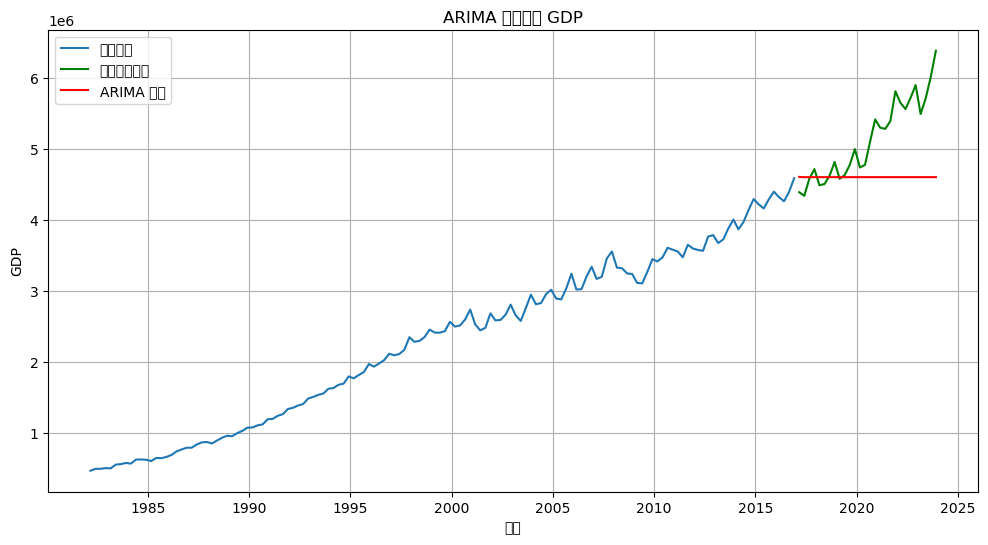

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


# 將年份與季別合併成 datetime 格式
def quarter_to_date(row):
    month = {1: 3, 2: 6, 3: 9, 4: 12}[row['季別']]
    return pd.Timestamp(year=row['年份'], month=month, day=1)

arima_train_y['日期'] = arima_train_y.apply(quarter_to_date, axis=1)
arima_test_y['日期'] = arima_test_y.apply(quarter_to_date, axis=1)

# 設定 index 為時間（讓它成為時間序列）
arima_train_y.set_index('日期', inplace=True)
arima_test_y.set_index('日期', inplace=True)

# 擷取訓練用的 GDP 時間序列
train_series = arima_train_y['GDP']

# 訓練 ARIMA 模型（這裡用 ARIMA(1,1,1) 作範例，可用 AIC/BIC 選最佳參數）
model = ARIMA(train_series, order=(1, 1, 1))
fitted_model = model.fit()

# 預測未來 n 筆資料（季為單位）
forecast_steps = len(arima_test_y)
forecast = fitted_model.forecast(steps=forecast_steps)

# 畫圖看一下效果
plt.figure(figsize=(12, 6))
plt.plot(train_series, label='訓練資料')
plt.plot(arima_test_y.index, test_y['GDP'], label='實際測試資料', color='green')
plt.plot(arima_test_y.index, forecast, label='ARIMA 預測', color='red')
plt.legend()
plt.title('ARIMA 模型預測 GDP')
plt.xlabel('時間')
plt.ylabel('GDP')
plt.grid(True)
plt.show()


In [23]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [24]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# 預測結果轉為 Series，對齊測試集 index
test_pred = pd.Series(forecast, index=arima_test_y.index)
test_actual = arima_test_y['GDP']

# 訓練集預測值與實際值對齊
train_actual = train_series
train_pred = fitted_model.fittedvalues

# 使用 align 確保 index 對齊
train_actual_aligned, train_pred_aligned = train_actual.align(train_pred, join='inner')

# === 測試集誤差指標 ===
test_mse = mean_squared_error(test_actual, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_actual, test_pred)

# === 訓練集誤差指標 ===
train_mse = mean_squared_error(train_actual_aligned, train_pred_aligned)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_actual_aligned, train_pred_aligned)

# 顯示結果
print("🔍 測試集誤差:")
print(f"  MSE:  {test_mse:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")

print("\n📘 訓練集誤差:")
print(f"  MSE:  {train_mse:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")


🔍 測試集誤差:
  MSE:  591369179947.11
  RMSE: 769005.32
  MAE:  582768.63

📘 訓練集誤差:
  MSE:  10116444032.29
  RMSE: 100580.54
  MAE:  73203.37
